In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from random import sample
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import shutil
from tensorflow.keras.applications import DenseNet121

In [2]:
! rm -rf /kaggle/working/*

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
!mkdir /kaggle/working/data

In [4]:
!cp -r /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca /kaggle/working/data
!cp -r /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_n /kaggle/working/data
!cp -r /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca /kaggle/working/data
!cp -r /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n /kaggle/working/data
!cp -r /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc /kaggle/working/data

In [6]:
data_path = "/kaggle/working/data"

In [7]:
test_path = 'test' 

if not os.path.exists(test_path):
    os.makedirs(test_path)

categories = os.listdir(data_path)

for category in categories:
    category_path = os.path.join(data_path, category)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        if len(images) >= 1000:
            test_images = sample(images, 1000)
            test_category_path = os.path.join(test_path, category)
            if not os.path.exists(test_category_path):
                os.makedirs(test_category_path)

            for img in test_images:
                img_path = os.path.join(category_path, img)
                shutil.move(img_path, test_category_path)
        else:
            print(f"Not enough images in {category} to move 1000 images.")


([0, 1, 2, 3, 4],
 [Text(0, 0, 'lung_n'),
  Text(1, 0, 'lung_aca'),
  Text(2, 0, 'colon_aca'),
  Text(3, 0, 'lung_scc'),
  Text(4, 0, 'colon_n')])

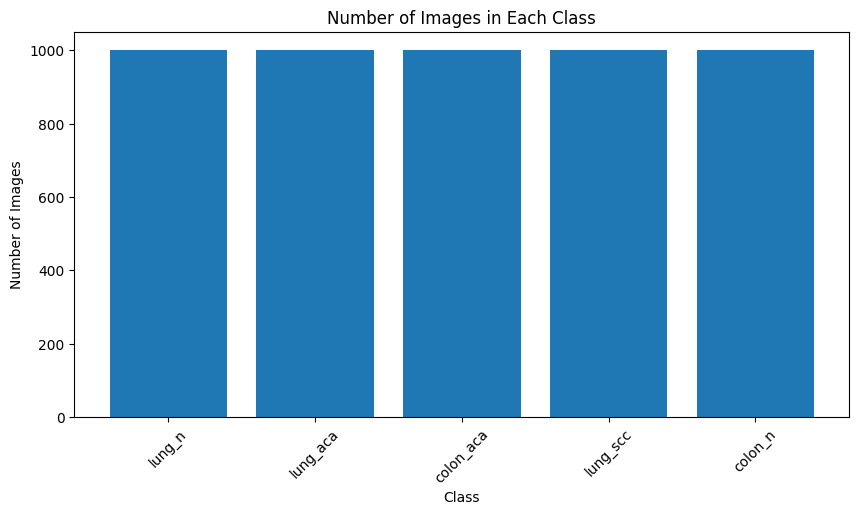

In [9]:
class_counts = {}

for class_name in os.listdir("/kaggle/working/test"):
    class_path = os.path.join("/kaggle/working/test", class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
plt.figure(figsize=(10, 5))
plt.bar(df['Class'], df['Count'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=45)

In [10]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=.2 )
IMG_SHAPE = (200,200)
BATCH_SIZE = 32
train_data = datagen.flow_from_directory(data_path,
                                         target_size=IMG_SHAPE,
                                         batch_size=BATCH_SIZE,
                                         subset="training",
                                         class_mode="categorical",
                                         color_mode="grayscale",
                                         shuffle=True)
valid_data = datagen.flow_from_directory(data_path,
                                         target_size=IMG_SHAPE,
                                         batch_size=BATCH_SIZE,
                                         subset="validation",
                                         class_mode="categorical",
                                         color_mode="grayscale",
                                         shuffle=False)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    '/kaggle/working/test',
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 16000 images belonging to 5 classes.
Found 4000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


In [11]:
class_names = list(train_data.class_indices.keys())
class_names

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

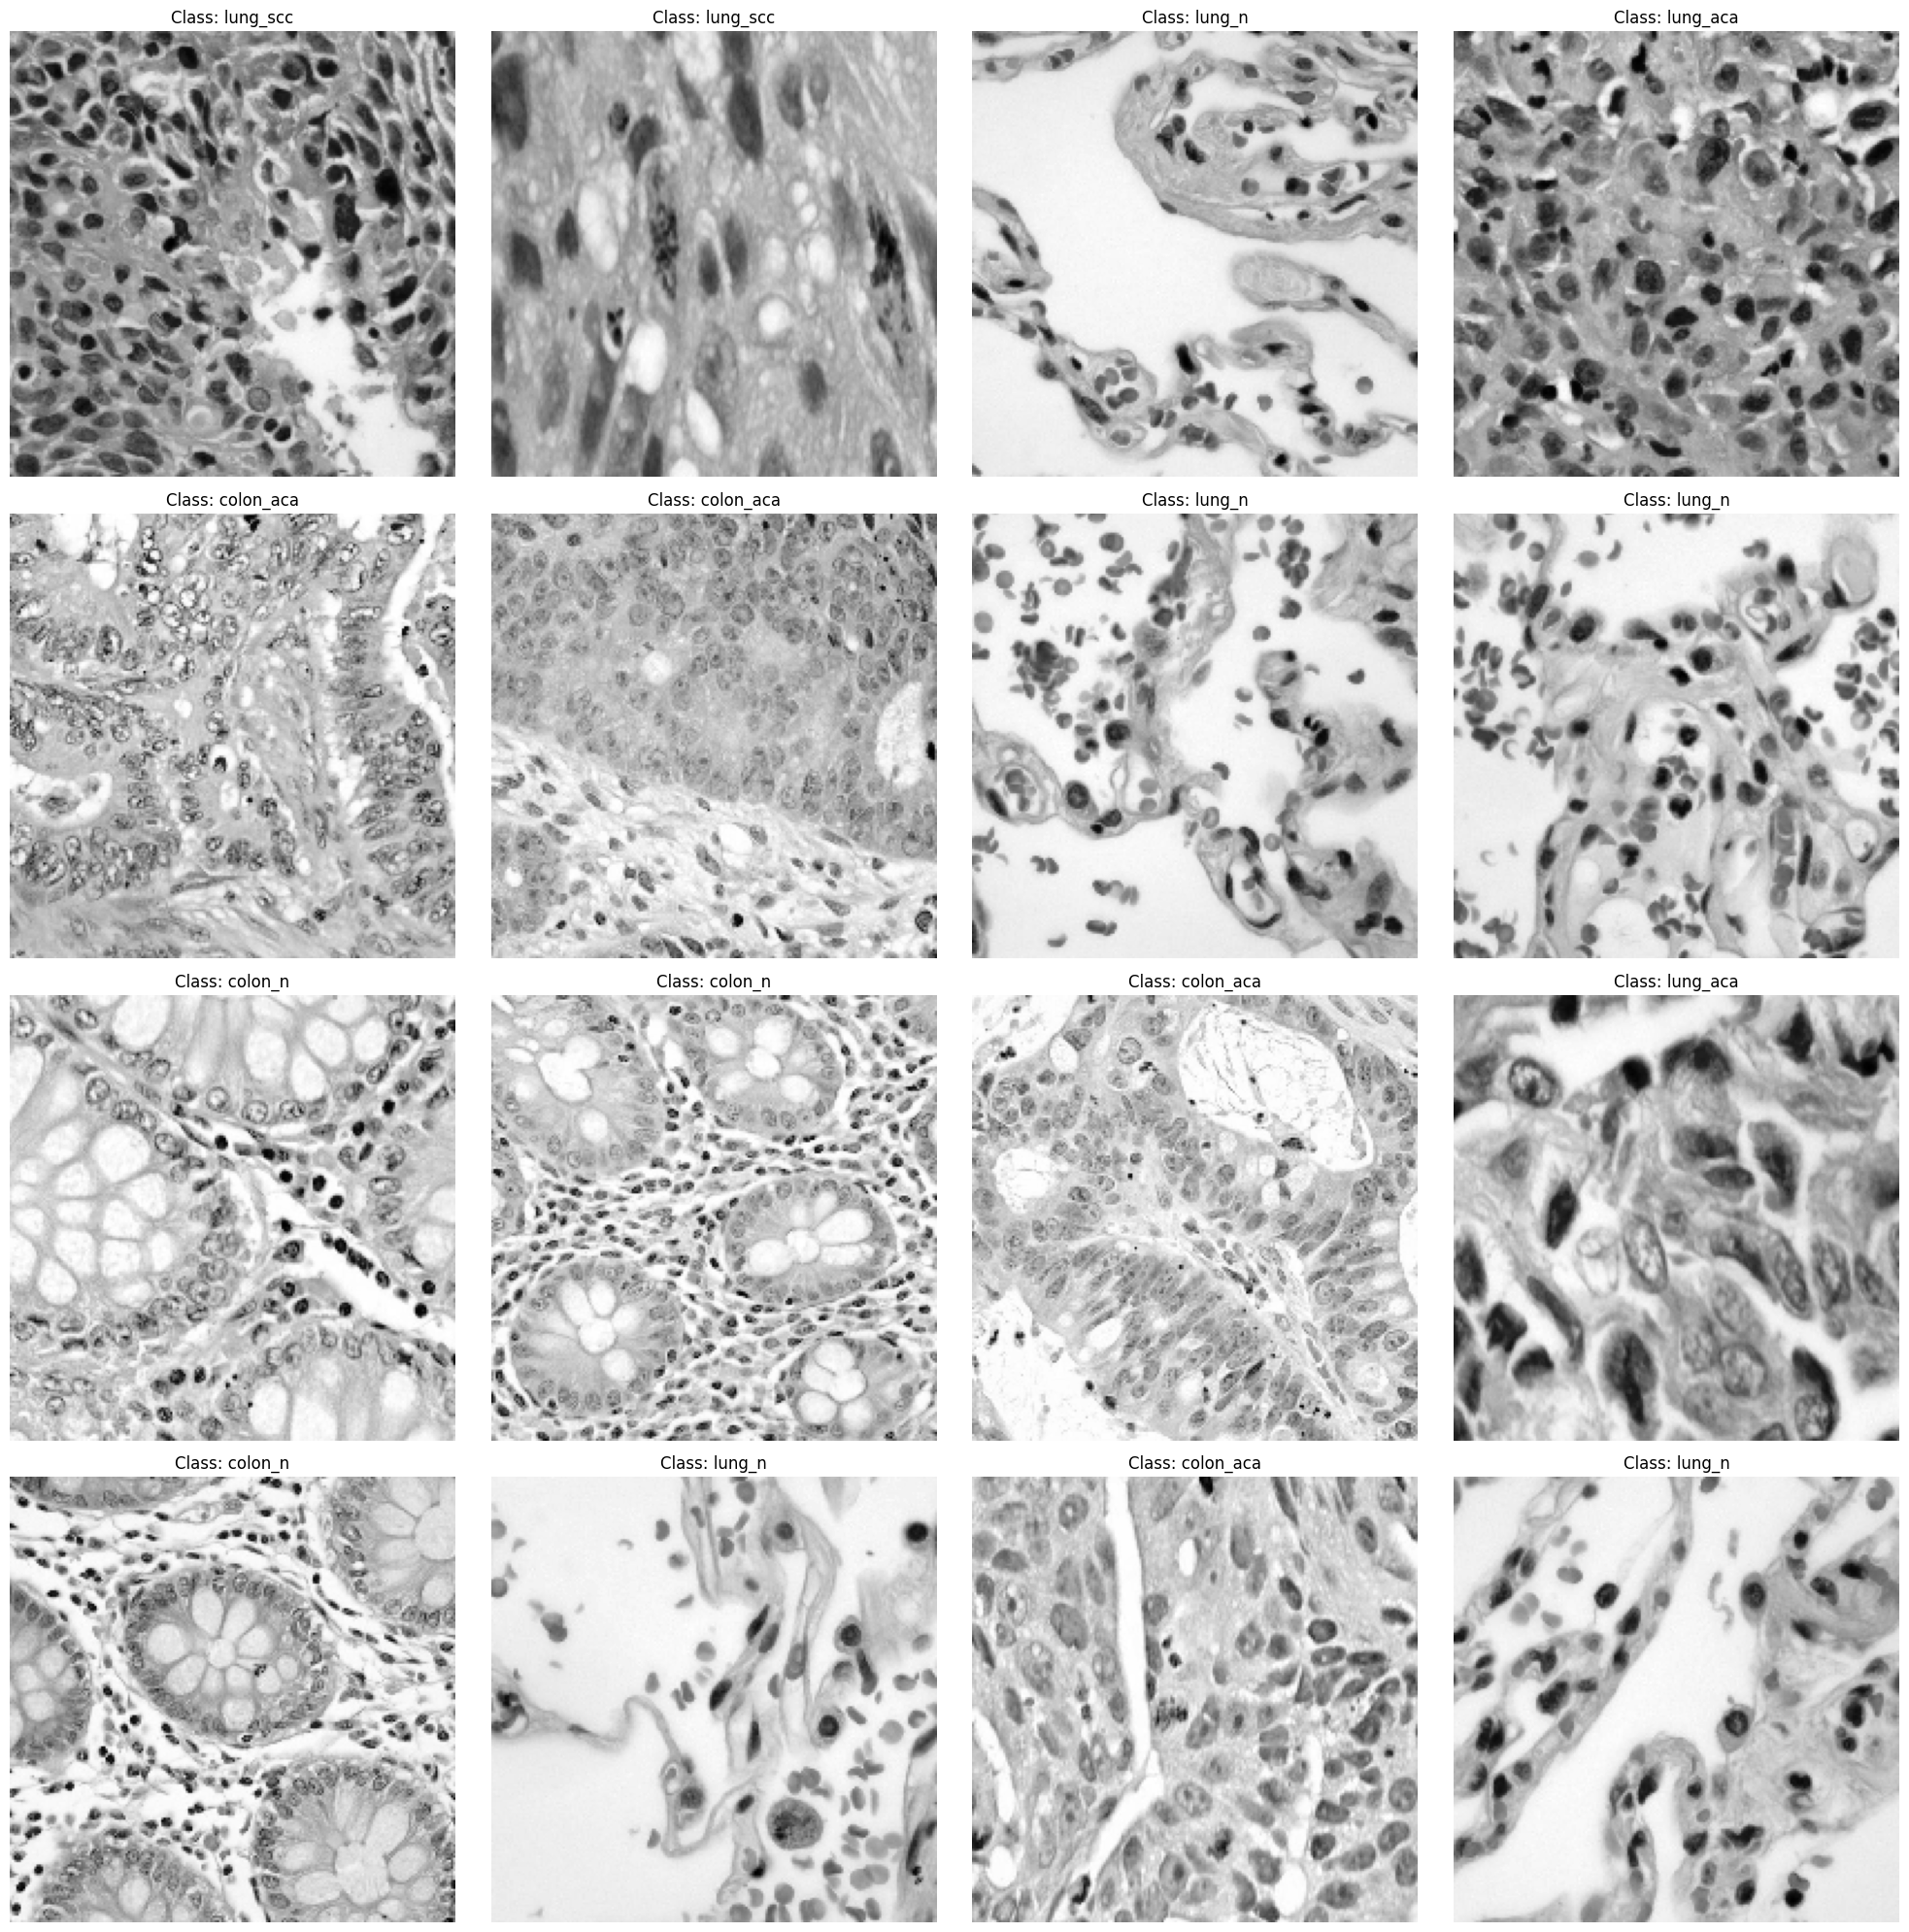

In [12]:
images, labels = next(train_data)
num_images = 16

plt.figure(figsize=(20, 20))
for i in range(num_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].reshape(IMG_SHAPE), cmap='gray')
    plt.title('Class: {}'.format(class_names[labels[i].argmax()]))
    plt.axis('off')

plt.tight_layout()
plt.show()

In [18]:
base_model = DenseNet121(weights=None, include_top=False, input_shape=(200, 200, 1))
base_model.trainable = True

In [25]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
          
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 206, 206,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 100, 100,  │      3,136 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 100, 100,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 100, 100,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 102, 102,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 50, 50,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 50, 50,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 50, 50,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 50, 50,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 50, 50,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 50, 50,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 50, 50,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 50, 50,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 50, 50,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 50, 50,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 50, 50,    │     12,288 │ conv2_block2_0_r

 Total params: 7,040,453 (26.86 MB)

 Trainable params: 6,954,757 (26.53 MB)

 Non-trainable params: 85,696 (334.75 KB)

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode="max")
checkpoint = ModelCheckpoint('Best_Weight_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=100,
    callbacks=[early_stopping,checkpoint]
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729081200.291158     138 service.cc:145] XLA service 0x7b6c84004020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729081200.291229     138 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1729081278.689127     138 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 239s 203ms/step - accuracy: 0.7944 - loss: 0.5938 - val_accuracy: 0.3695 - val_loss: 17.0850
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 93s 184ms/step - accuracy: 0.8957 - loss: 0.2690 - val_accuracy: 0.5280 - val_loss: 1.8749
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 91s 180ms/step - accuracy: 0.9278 - loss: 0.1836 - val_accuracy: 0.4527 - val_loss: 10.4052
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 91s 180ms/step - accuracy: 0.9396 - loss: 0.1565 - val_accuracy: 0.3915 - val_loss: 6.6112
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 93s 185ms/step - accuracy: 0.9529 - loss: 0.1281 - val_accuracy: 0.5755 - val_loss: 1.6056
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 91s 181ms/step - accuracy: 0.9623 - loss: 0.1007 - val_accuracy: 0.3570 - val_loss: 9.8736
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 92s 182ms/step - accuracy: 0.9532 - loss: 0.1386 - val_accuracy: 0.5610 - val_loss: 3.8565
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 93s 185ms/step - accuracy: 0.9701 - loss: 0.

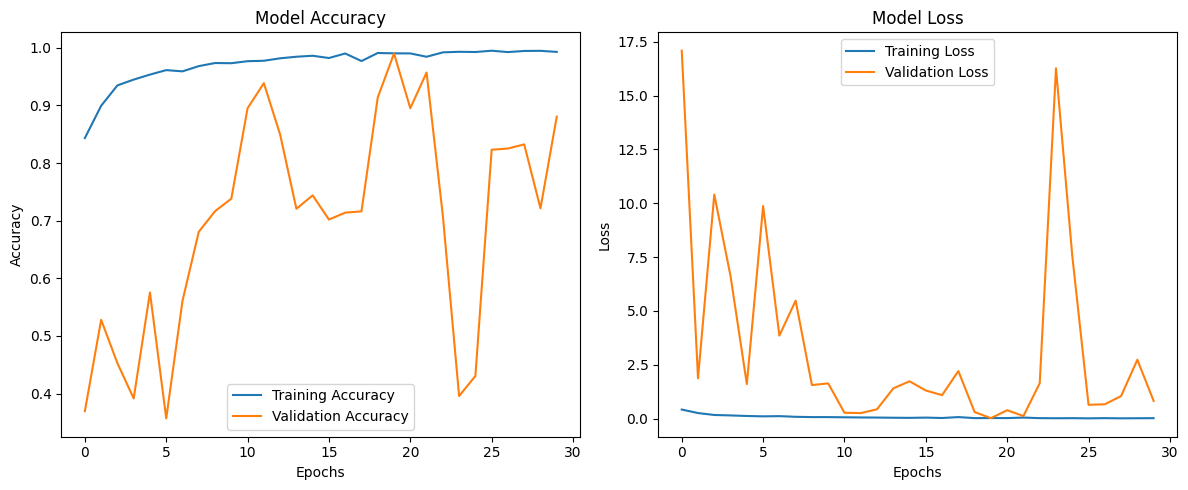

In [28]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
model.evaluate(test_data)

157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 170ms/step - accuracy: 0.9962 - loss: 0.0113


[0.02115730755031109, 0.9932000041007996]

In [30]:
test_labels = test_data.classes


predictions = model.predict(test_data)
predicted_labels = predictions.argmax(axis=1)


report = classification_report(test_labels, predicted_labels, target_names=test_data.class_indices.keys())
print(report)

157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 166ms/step
              precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00      1000
     colon_n       1.00      1.00      1.00      1000
    lung_aca       0.99      0.98      0.98      1000
      lung_n       1.00      1.00      1.00      1000
    lung_scc       0.98      0.99      0.98      1000

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step


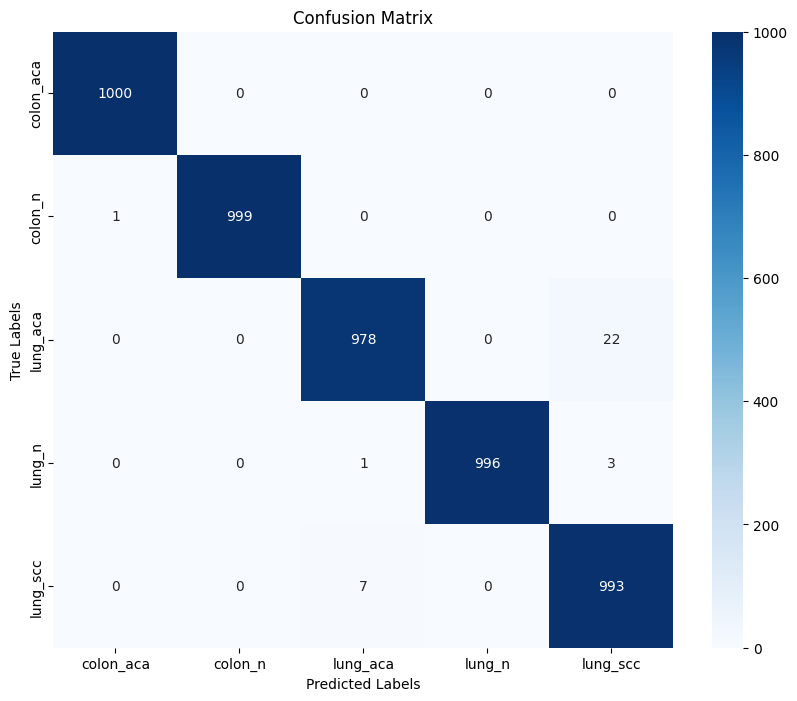

In [31]:
test_labels = test_data.classes

predictions = model.predict(test_data)
predicted_labels = predictions.argmax(axis=1)

cm = confusion_matrix(test_labels, predicted_labels)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [32]:
model.save("model.h5")